In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

from scipy.optimize import minimize

print(123)

123


In [2]:
def tubular_reactor_model(t, y, u, params):
    x1 = y[0]
    x2 = y[1]
    dx1dz = (
        params["alpha"]
        / params["v"]
        * (1 - x1)
        * np.exp(params["gamma"] * x2 / (1 + x2))
    )
    dx2dz = params["alpha"] * params["delta"] / params["v"] * (1 - x1) * np.exp(
        params["gamma"] * x2 / (1 + x2)
    ) + params["beta"] / params["v"] * (u - x2)
    return np.array([dx1dz, dx2dz])

In [3]:
params = {}
params["v"] = 0.1  # m/s
params["L"] = 1  # m
params["alpha"] = 0.058  # 1/s
params["beta"] = 0.2  # 1/s
params["gamma"] = 16.7  #
params["delta"] = 0.25  #
params["cin"] = 0.02  # mol/L
params["Tin"] = 340  # K
y0 = np.zeros(2)
zspan = [0, params["L"]]
u = 0  # This is the normalized wall temperature
sol = solve_ivp(lambda t, y: tubular_reactor_model(t, y, u, params), zspan, y0)
z = sol.t
x1 = sol.y[0, :]
x2 = sol.y[1, :]

T = params["Tin"] * (1 + x2)
c = params["cin"] * (1 - x1)
Tw = params["Tin"] * (1 + u)

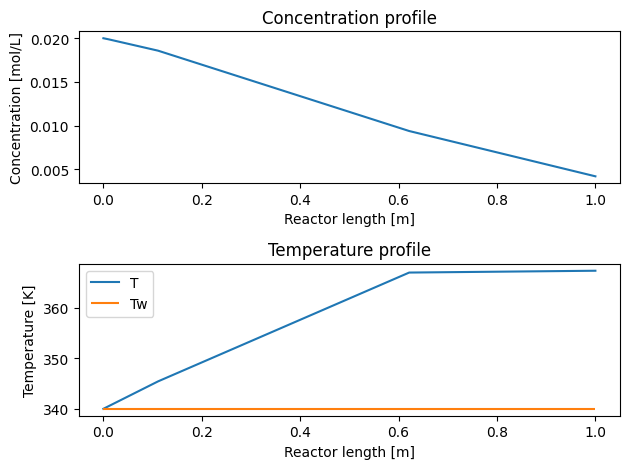

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(z, c)
ax1.set_xlabel("Reactor length [m]")
ax1.set_ylabel("Concentration [mol/L]")
ax1.set_title("Concentration profile")
ax2 = plt.subplot(2, 1, 2)
ax2.plot(z, T, label="T")
ax2.hlines(y=Tw, label="Tw", xmin=z[0], xmax=z[-1], color="tab:orange")
ax2.set_xlabel("Reactor length [m]")
ax2.set_ylabel("Temperature [K]")
ax2.set_title("Temperature profile")
ax2.legend()
fig.tight_layout()  # Tries to force all elements in the figure (labels, titles␣

In [5]:
def sim(u, params):
    u = u[0]
    y0 = np.zeros(2)
    zspan = [0, params["L"]]
    sol = solve_ivp(lambda t, y: tubular_reactor_model(t, y, u, params), zspan, y0)
    z = sol.t
    x1 = sol.y[0, :]
    x2 = sol.y[1, :]
    T = params["Tin"] * (1 + x2)
    c = params["cin"] * (1 - x1)
    Tw = params["Tin"] * (1 + u)
    return z, c, T, Tw, x1, x2


def obj(u, params, print_vals=False):
    z, c, T, Tw, x1, x2 = sim(u, params)
    J = 1 - x1
    Q = J[-1]
    if print_vals == True:
        print(f"u = {u}, Q = {Q}")
    return Q

In [6]:
params["c_lb"] = 0
params["c_ub"] = 0.02
params["T_lb"] = 280
params["T_ub"] = 400
params["Tw_lb"] = 280
params["Tw_ub"] = 400

In [7]:
def const(u, params):
    z, c, T, Tw, x1, x2 = sim(u, params)
    con = [
        params["T_ub"]
        - np.max(T),  # No temperature in the reactor may␣,→exceed the maximum
        np.min(T) - params["T_lb"],
    ]  # No temperature in the reactor may go␣below the minimum
    return con


con = {"type": "ineq", "fun": lambda u: const(u, params)}
x_lb = (params["Tw_lb"] - params["Tin"]) / params["Tin"]
x_ub = (params["Tw_ub"] - params["Tin"]) / params["Tin"]
bounds = [[x_lb, x_ub]]

res = minimize(
    lambda u: obj(u, params, print_vals=True),
    x0=0,
    bounds=bounds,
    method="SLSQP",
    constraints=con,
)
print(res)

u = [0.], Q = 0.20984505241235896
u = [1.49011612e-08], Q = 0.20984496512272488
u = [0.06959879], Q = 0.011672198157343994
u = [0.0695988], Q = 0.011672189365330654
u = [0.06370966], Q = 0.015641483091059394
u = [0.06370967], Q = 0.015641471691495545
u = [0.06390113], Q = 0.015495612733262276
u = [0.06390115], Q = 0.015495601428338501
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.015495612733262276
       x: [ 6.390e-02]
     nit: 4
     jac: [-7.587e-01]
    nfev: 8
    njev: 4


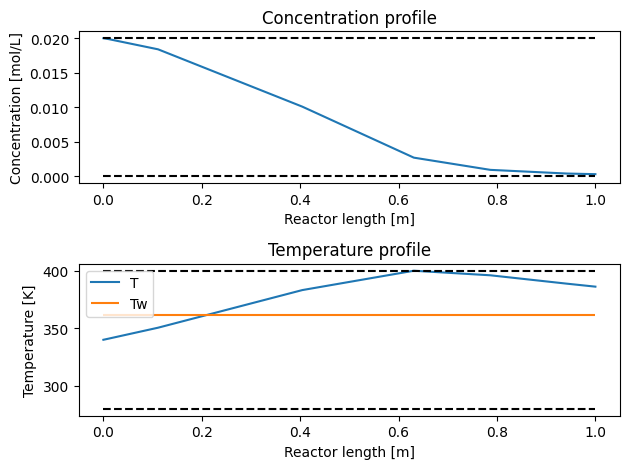

In [8]:
xopt = res.x
z, c, T, Tw, x1, x2 = sim(xopt, params)
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(z, c)
ax1.hlines(y=params["c_lb"], xmin=z[0], xmax=z[-1], color="black", linestyle="--")
ax1.hlines(y=params["c_ub"], xmin=z[0], xmax=z[-1], color="black", linestyle="--")
ax1.set_xlabel("Reactor length [m]")
ax1.set_ylabel("Concentration [mol/L]")
ax1.set_title("Concentration profile")
ax2 = plt.subplot(2, 1, 2)
ax2.plot(z, T, label="T")
ax2.hlines(y=Tw, label="Tw", xmin=z[0], xmax=z[-1], color="tab:orange")
ax2.hlines(y=params["T_lb"], xmin=z[0], xmax=z[-1], color="black", linestyle="--")
ax2.hlines(y=params["T_ub"], xmin=z[0], xmax=z[-1], color="black", linestyle="--")
ax2.set_xlabel("Reactor length [m]")
ax2.set_ylabel("Temperature [K]")
ax2.set_title("Temperature profile")
ax2.legend()
fig.tight_layout()

In [9]:
def sim_segments(u, params):
    y0 = np.zeros(2)
    segment_length = params['L']/10
    6
    ysol = np.zeros((2, 11)) # An array for the outlet concentrations and␣temperatures of all segments + the first inlet concentration
    zsol = np.zeros(11) # An array for the z-coordinates of all segment outlets␣+ the inlet
    for i in range(10):
        zspan = [i*segment_length, (i+1)*segment_length]
        sol = solve_ivp(lambda t,y: tubular_reactor_model(t, y, u[i], params),zspan, y0)
        ysol[:, i+1] = sol.y[:, -1]
        y0 = sol.y[:, -1]
        zsol[i+1] = (i+1)*segment_length
    x1 = ysol[0,:]
    x2 = ysol[1,:]
    T = params['Tin']*(1 + x2)
    c = params['cin']*(1 - x1)
    Tw = params['Tin']*(1 + u)
    return zsol, c, T, Tw, x1, x2

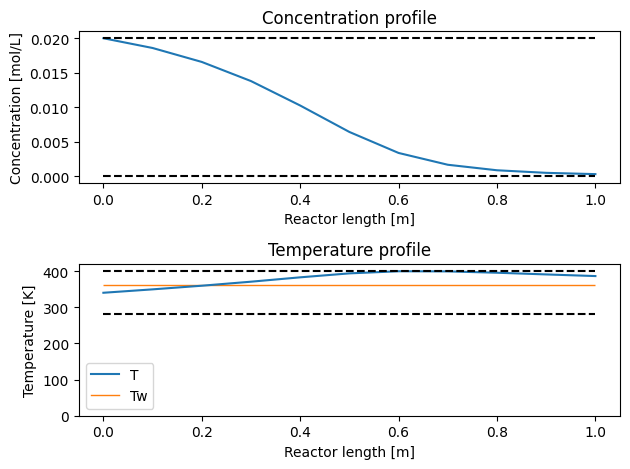

In [10]:
#10
u = np.hstack((xopt*np.ones(5),1*xopt*np.ones(5)))
z, c, T, Tw, x1, x2 = sim_segments(u, params)
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.plot(z, c)
ax1.hlines(y = params['c_lb'], xmin=z[0],xmax=z[-1], color='black',linestyle='--')
ax1.hlines(y = params['c_ub'], xmin=z[0],xmax=z[-1], color='black',linestyle='--')
ax1.set_xlabel('Reactor length [m]')
ax1.set_ylabel('Concentration [mol/L]')
ax1.set_title('Concentration profile')
ax2 = plt.subplot(2,1,2)
ax2.plot(z, T, label='T')
# Create an array of coordinates for each segment's end points
segments = np.linspace(0,1,len(Tw)+1)

# Plot the segments as a stair diagram. See matplotlib's documentation for more␣info!
ax2.stairs(Tw, segments, color = 'tab:orange', baseline = None, label = 'Tw')
ax2.hlines(y = params['T_lb'], xmin=z[0], xmax=z[-1], color='black',linestyle='--')
ax2.hlines(y = params['T_ub'], xmin=z[0], xmax=z[-1], color='black',linestyle='--')
ax2.set_xlabel('Reactor length [m]')
ax2.set_ylabel('Temperature [K]')
ax2.set_title('Temperature profile')
ax2.legend()
fig.tight_layout()

In [11]:
# 11
def obj_segments(u, params, print_vals=False):
    z, c, T, Tw, x1, x2 = sim_segments(u, params)
    J = 1 - x1
    Q = J[-1]
    if print_vals == True:
        pass
        # print(u, Q)
    return Q


def const_segments(u, params):
    z, c, T, Tw, x1, x2 = sim_segments(u, params)
    con = np.hstack(([params["T_ub"] - T, T - params["T_lb"]]))
    return con


con_segments = {"type": "ineq", "fun": lambda u: const_segments(u, params)}

# 12
bounds_segments = [[x_lb, x_ub]] * 10
print("=" * 100)

init_guess = (x_ub - x_lb) / 2 * np.ones(10)
init_guess_2 = x_ub * np.ones(10)


# 13
res = minimize(
    lambda u: obj_segments(u, params, print_vals=False),
    x0=init_guess,
    bounds=bounds_segments,
    method="SLSQP",
    constraints=con_segments,
)
# print(f"res.x: {res.x}")
conversion = 1 - res.fun
# print(f"conversion = {conversion}")
Tjackets = params["Tin"] * (1 + res.x)
# print(f"Tjackets = {Tjackets}")
combined = np.vstack((Tjackets, res.x)).T
np.set_printoptions(suppress=True)
print(f"combined = {combined}")


combined = [[400.           0.17647059]
 [400.           0.17647059]
 [373.71839012   0.09917174]
 [299.99010117  -0.11767617]
 [353.11996589   0.03858813]
 [377.44451262   0.11013092]
 [389.02420417   0.14418884]
 [394.63105121   0.16067956]
 [397.36723579   0.16872716]
 [398.70731989   0.17266859]]


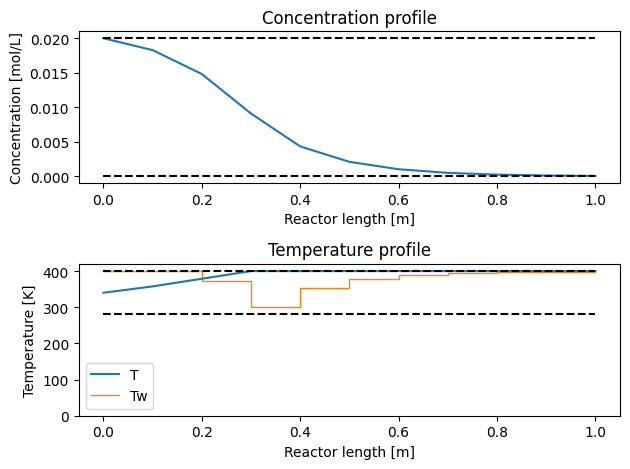

In [12]:
# 14
z, c, T, Tw, x1, x2 = sim_segments(res.x, params)
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(z, c)
ax1.hlines(y=params["c_lb"], xmin=z[0], xmax=z[-1], color="black", linestyle="--")
ax1.hlines(y=params["c_ub"], xmin=z[0], xmax=z[-1], color="black", linestyle="--")
ax1.set_xlabel("Reactor length [m]")
ax1.set_ylabel("Concentration [mol/L]")
ax1.set_title("Concentration profile")
ax2 = plt.subplot(2, 1, 2)
ax2.plot(z, T, label="T")
# Create an array of coordinates for each segment's end points
segments = np.linspace(0, 1, len(Tw) + 1)
# Plot the segments as a stair diagram. See matplotlib's documentation for more info!
ax2.stairs(Tw, segments, color="tab:orange", baseline=None, label="Tw")
ax2.hlines(y=params["T_lb"], xmin=z[0], xmax=z[-1], color="black", linestyle="--")
ax2.hlines(y=params["T_ub"], xmin=z[0], xmax=z[-1], color="black", linestyle="--")
ax2.set_xlabel("Reactor length [m]")
ax2.set_ylabel("Temperature [K]")
ax2.set_title("Temperature profile")
ax2.legend()
fig.tight_layout()